In [1]:
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

# Set random seed for reproducibility
manualSeed = 999
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)
torch.use_deterministic_algorithms(True) # Needed for reproducible results


Random Seed:  999


In [2]:
# Root directory for dataset
dataroot = "/kaggle/input/chest-xray-pneumoniacovid19tuberculosis"  # Change this to the path where your dataset is located

# Number of workers for dataloader
workers = 2

# Batch size during training
batch_size = 128

# Spatial size of training images. All images will be resized to this
image_size = 64

# Number of channels in the training images. For color images this is 3
nc = 3

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# Number of training epochs
num_epochs = 50

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparameter for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

# Paths for the COVID and TB folders where generated images will be saved
covid_path = os.path.join(dataroot, 'train/COVID19')
tb_path = os.path.join(dataroot, 'train/TUBERCULOSIS')


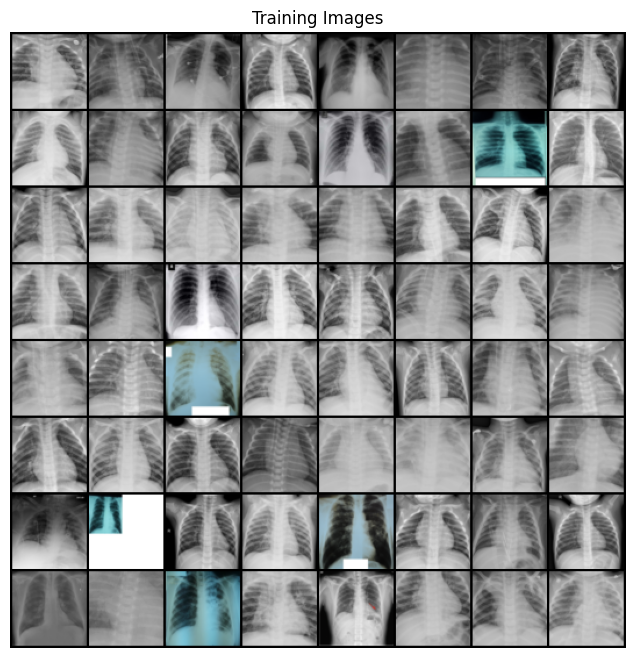

In [3]:
# Create the dataset
dataset = dset.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))

# Create the dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))
plt.show()


In [4]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)


In [5]:
class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d(nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, input):
        return self.main(input)


In [6]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)


In [7]:
# Create the Discriminator and Generator
netG = Generator(ngpu).to(device)
netD = Discriminator(ngpu).to(device)

# Apply weight initialization
netG.apply(weights_init)
netD.apply(weights_init)

# Create Adam optimizers for G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

# Initialize BCELoss function
criterion = nn.BCELoss()

# Fixed noise to track progress of G
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# Real and fake labels during training
real_label = 1.
fake_label = 0.

# Train the model
img_list = []
G_losses = []
D_losses = []
iters = 0

for epoch in range(num_epochs):
    for i, data in enumerate(dataloader, 0):
        
        ##########################
        # (1) Update D network
        ##########################
        netD.zero_grad()
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        output = netD(real_cpu).view(-1)
        errD_real = criterion(output, label)
        errD_real.backward()
        D_x = output.mean().item()

        noise = torch.randn(b_size, nz, 1, 1, device=device)
        fake = netG(noise)
        label.fill_(fake_label)
        output = netD(fake.detach()).view(-1)
        errD_fake = criterion(output, label)
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        errD = errD_real + errD_fake
        optimizerD.step()

        ##########################
        # (2) Update G network
        ##########################
        netG.zero_grad()
        label.fill_(real_label)
        output = netD(fake).view(-1)
        errG = criterion(output, label)
        errG.backward()
        D_G_z2 = output.mean().item()
        optimizerG.step()

        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        G_losses.append(errG.item())
        D_losses.append(errD.item())

        if iters % 500 == 0:
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1


[0/50][0/56]	Loss_D: 2.0365	Loss_G: 3.8016	D(x): 0.4007	D(G(z)): 0.5501 / 0.0345
[0/50][50/56]	Loss_D: 0.8530	Loss_G: 24.8229	D(x): 0.9893	D(G(z)): 0.4357 / 0.0000
[1/50][0/56]	Loss_D: 0.1332	Loss_G: 12.4436	D(x): 0.9795	D(G(z)): 0.0681 / 0.0000
[1/50][50/56]	Loss_D: 0.8323	Loss_G: 9.3866	D(x): 0.8898	D(G(z)): 0.4313 / 0.0001
[2/50][0/56]	Loss_D: 0.9962	Loss_G: 12.8931	D(x): 0.5221	D(G(z)): 0.0001 / 0.0000
[2/50][50/56]	Loss_D: 0.4278	Loss_G: 5.4141	D(x): 0.8629	D(G(z)): 0.1954 / 0.0071
[3/50][0/56]	Loss_D: 0.5079	Loss_G: 5.4787	D(x): 0.7079	D(G(z)): 0.0087 / 0.0071
[3/50][50/56]	Loss_D: 0.3184	Loss_G: 3.7869	D(x): 0.8062	D(G(z)): 0.0196 / 0.0491
[4/50][0/56]	Loss_D: 0.5929	Loss_G: 3.2005	D(x): 0.7578	D(G(z)): 0.1921 / 0.0600
[4/50][50/56]	Loss_D: 0.6043	Loss_G: 2.7252	D(x): 0.6881	D(G(z)): 0.1210 / 0.1067
[5/50][0/56]	Loss_D: 0.4494	Loss_G: 3.5494	D(x): 0.8303	D(G(z)): 0.2044 / 0.0373
[5/50][50/56]	Loss_D: 0.5072	Loss_G: 3.4941	D(x): 0.7826	D(G(z)): 0.1819 / 0.0501
[6/50][0/56]	Loss_D

In [8]:
import os

# Function to generate synthetic images and save them to specified folder
def generate_synthetic_images(generator, num_images, class_folder):
    os.makedirs(class_folder, exist_ok=True)  # Create the folder if it doesn't exist
    
    for i in range(num_images):
        noise = torch.randn(1, nz, 1, 1, device=device)  # Latent vector
        fake_image = generator(noise).detach().cpu()  # Generate image
        # Save the generated image
        vutils.save_image(fake_image, os.path.join(class_folder, f"fake_{i + 1}.png"), normalize=True)

# Define the output folder in the writeable directory (Kaggle's working directory)
output_dir = '/kaggle/working/synthetic_images'

# Create synthetic image folders for COVID19 and Tuberculosis
generate_synthetic_images(netG, 3415, os.path.join(output_dir, "COVID19"))
generate_synthetic_images(netG, 3225, os.path.join(output_dir, "TUBERCULOSIS"))

print("Synthetic image generation completed.")


Synthetic image generation completed.


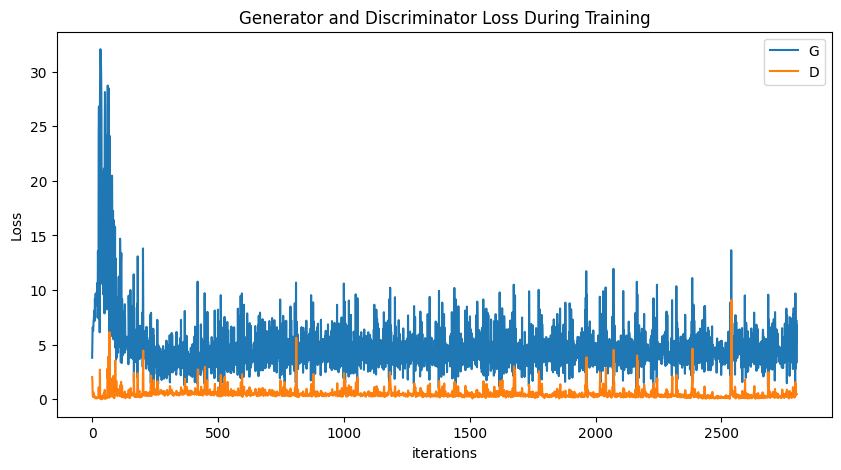

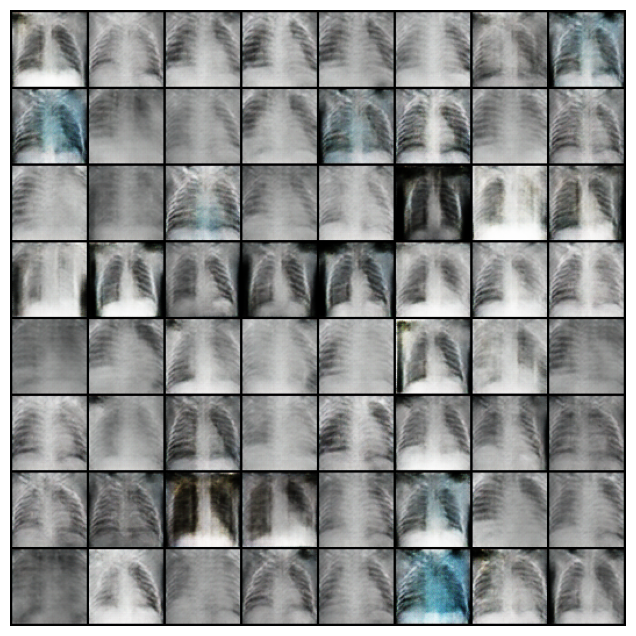

In [9]:
# Plot the Generator and Discriminator Losses
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Visualize the real and fake images
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)
HTML(ani.to_jshtml())
